In [4]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.9 MB/s 
     |████████████████████████████████| 5.5 MB 55.3 MB/s 
     |████████████████████████████████| 1.3 MB 49.2 MB/s 
     |████████████████████████████████| 163 kB 72.2 MB/s 
     |████████████████████████████████| 7.6 MB 58.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=5a6f3df6ed85c70566105d11c0a33806856ab1f98ea5484128ef0222af76aae9
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [5]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 30.8 MB/s 
     |████████████████████████████████| 81 kB 11.8 MB/s 
     |████████████████████████████████| 209 kB 75.0 MB/s 
     |████████████████████████████████| 78 kB 9.3 MB/s 
     |████████████████████████████████| 112 kB 56.0 MB/s 
     |████████████████████████████████| 147 kB 74.2 MB/s 
     |████████████████████████████████| 50 kB 8.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=e00ba8cd96dc588950f1b2719888e84ab9d2382beef7ee3057e2dd7fffd66952
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [6]:
import numpy as np 
import pandas as pd
import random
import keras
import torch
import tensorflow as tf
import optuna
from optuna import Trial
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import os
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import log_loss
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn import metrics
SEED = 99
def random_seed(SEED):
  random.seed(SEED)
  os.environ['PYTHONHASHSEED'] = str(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)
  torch.backends.cudnn.deterministic = True
  tf.random.set_seed(SEED)
random_seed(SEED)

In [7]:

train_data1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dylatics/dyla_dummy.csv')
train_data1.head()

,Unnamed: 0,Review,Tag 1,Tag 2,Tag 3,Tag 4,Tag 5
0,0,For some reasons everybody complains about them,0,0,0,1,0
1,1,"I like everything about it, great choice",1,0,0,0,1
2,2,excellent ceiling fan brace. Easy to install,0,0,1,0,1
3,3,work great. Easy to use.,1,0,0,1,1
4,4,I would recommend this product.,0,0,1,0,1


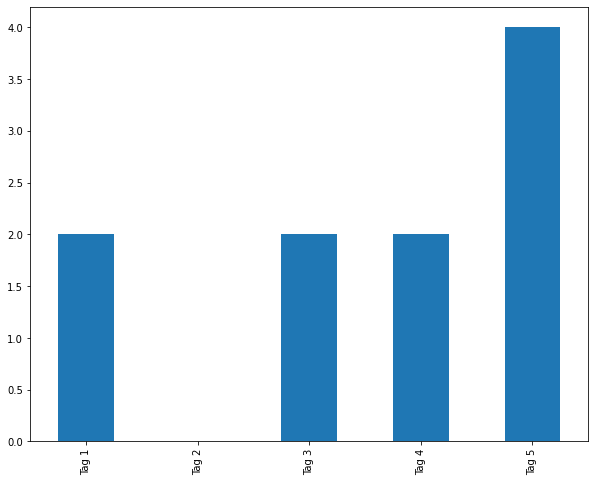

In [9]:
comments_labels = train_data1[['Tag 1','Tag 2','Tag 3','Tag 4','Tag 5']]
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
comments_labels.sum(axis=0).plot.bar()

In [10]:
model = SentenceTransformer('bert-base-uncased')
model.max_seq_length = 512
print("Max Sequence Length:", model.max_seq_length)
sentence_embeddings = model.encode(train_data1['Review'])

Downloading:   0%|          | 0.00/437 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Max Sequence Length: 512


In [11]:
train1_x, test_x, train1_y, test_y = train_test_split(sentence_embeddings, 
                                                      comments_labels, 
                                                      train_size=0.8, 
                                                      test_size=0.2, 
                                                      random_state=42)

In [15]:
def objective(trial):
    keras.backend.clear_session()
    train_x, valid_x, train_y, valid_y = train_test_split(train1_x, train1_y, train_size=0.8, test_size=0.2,
                                                                random_state=42)
    #optimum number of hidden layers
    n_layers = trial.suggest_int('n_layers', 1, 3)
    model = keras.Sequential()
    for i in range(n_layers):
        #optimum number of hidden nodes
        num_hidden = trial.suggest_int(f'n_units_l{i}', 48, len(sentence_embeddings[0]), log=True)
        #optimum activation function
        model.add(keras.layers.Dense(num_hidden, input_shape=(len(sentence_embeddings[0]),),
                                     activation=trial.suggest_categorical(f'activation{i}', ['relu', 'linear','swish'])))
        #optimum dropout value
        model.add(keras.layers.Dropout(rate = trial.suggest_float(f'dropout{i}', 0.0, 0.6))) 
        model.add(keras.layers.Dense(5,activation=tf.keras.activations.sigmoid)) #output Layer
        val_ds = (valid_x,valid_y)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=1,min_lr=1e-05,verbose=0)
        early_stoping = EarlyStopping(monitor="val_loss",min_delta=0,patience=5,verbose=0,mode="auto", baseline=None,restore_best_weights=True)
        model.compile(loss='binary_crossentropy',metrics='categorical_crossentropy', optimizer='Adam')
        #optimum batch size
        histroy = model.fit(train_x,train_y, validation_data=val_ds,epochs=200,callbacks=[reduce_lr,early_stoping],verbose=0,
                            batch_size=trial.suggest_int('size', 8, 128))
        return min(histroy.history['val_loss'])

In [16]:
if __name__ == "__main__":
  study = optuna.create_study(direction="minimize")
  study.optimize(objective, n_trials=50, timeout=1200)
  print("Number of finished trials: {}".format(len(study.trials)))
  print("Best trial:")
  trial = study.best_trial
  print("  Value: {}".format(trial.value))

[I 2022-11-14 19:56:09,379] A new study created in memory with name: no-name-af6f6053-4842-40b7-975b-f1a9247ee1ca
[I 2022-11-14 19:56:12,677] Trial 0 finished with value: 0.7606489062309265 and parameters: {'n_layers': 2, 'n_units_l0': 135, 'activation0': 'relu', 'dropout0': 0.1392662235547911, 'size': 56}. Best is trial 0 with value: 0.7606489062309265.
[I 2022-11-14 19:56:13,498] Trial 1 finished with value: 0.7210731506347656 and parameters: {'n_layers': 2, 'n_units_l0': 78, 'activation0': 'swish', 'dropout0': 0.2035912309577391, 'size': 14}. Best is trial 1 with value: 0.7210731506347656.
[I 2022-11-14 19:56:14,317] Trial 2 finished with value: 0.7430760860443115 and parameters: {'n_layers': 3, 'n_units_l0': 150, 'activation0': 'linear', 'dropout0': 0.5068276061174142, 'size': 117}. Best is trial 1 with value: 0.7210731506347656.
[I 2022-11-14 19:56:15,094] Trial 3 finished with value: 0.6294665336608887 and parameters: {'n_layers': 3, 'n_units_l0': 365, 'activation0': 'linear', 'd

Number of finished trials: 50
Best trial:
  Value: 0.5160613656044006


In [17]:
optuna.visualization.plot_optimization_history(study)

In [18]:
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

  Params: 
    n_layers: 3
    n_units_l0: 162
    activation0: linear
    dropout0: 0.03620246108357774
    size: 12


In [19]:
def wider_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(682,input_shape=(len(sentence_embeddings[0]),),activation=tf.keras.activations.relu))
    model.add(keras.layers.Dropout(0.42199525694641216))
    model.add(keras.layers.Dense(5,activation=tf.keras.activations.sigmoid))
    return model

In [21]:
skf = KFold(n_splits=2, shuffle=True, random_state=1234)
Final_Subbmission = []
val_loss_print = []
i=1
for train_index, test_index in skf.split(train1_x,train1_y):
    keras.backend.clear_session()
    print('#################')
    print(i)
    print('#################')
    X_train, X_test = train1_x[train_index], train1_x[test_index]
    y_train, y_test = train1_y.iloc[train_index], train1_y.iloc[test_index]
    model = wider_model()
    val_ds = (X_test,y_test)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=1,min_lr=1e-05,verbose=1)
    early_stoping = EarlyStopping(monitor="val_loss",min_delta=0,patience=5,verbose=1,mode="auto", baseline=None,restore_best_weights=True)
    model.compile(loss='binary_crossentropy',metrics='categorical_crossentropy', optimizer='Adam')
    histroy = model.fit(X_train,y_train, validation_data=val_ds,epochs=200,callbacks=[reduce_lr,early_stoping],verbose=1,batch_size=34)
    print(min(histroy.history['val_loss']))
    val_loss_print.append(min(histroy.history['val_loss']))
    Test_seq_pred = model.predict(test_x)
    Final_Subbmission.append(Test_seq_pred)
    i=i+1

#################
1
#################
Epoch 1/200
1/1 [==============================] - 1s 612ms/step - loss: 0.8299 - categorical_crossentropy: 4.1213 - val_loss: 0.7644 - val_categorical_crossentropy: 3.6864 - lr: 0.0010
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 0.4481 - categorical_crossentropy: 2.3995
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1/1 [==============================] - 0s 31ms/step - loss: 0.4481 - categorical_crossentropy: 2.3995 - val_loss: 0.8527 - val_categorical_crossentropy: 4.2631 - lr: 0.0010
Epoch 3/200
1/1 [==============================] - ETA: 0s - loss: 0.2367 - categorical_crossentropy: 1.9086
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1/1 [==============================] - 0s 29ms/step - loss: 0.2367 - categorical_crossentropy: 1.9086 - val_loss: 0.8629 - val_categorical_crossentropy: 4.3288 - lr: 1.0000e-04
Epoch 4/200
1/1 [==============================] - ETA

In [28]:
Final_Subbmission



[array([[0.5652714 , 0.38295773, 0.27984396, 0.50416696, 0.47114825]],
       dtype=float32),
 array([[0.48666954, 0.35243955, 0.6023197 , 0.30639008, 0.6730629 ]],
       dtype=float32)]

In [25]:
Test_prob =np.mean(Final_Subbmission,0)
Test_prob = pd.DataFrame(Test_prob)
Test_prob.columns = comments_labels.columns
Test_prob

,Tag 1,Tag 2,Tag 3,Tag 4,Tag 5
0,0.52597,0.367699,0.441082,0.405279,0.572106


In [23]:
test_y1 = test_y.reset_index(drop=True)
print("weighted: {:.2f} ".format( metrics.average_precision_score(test_y1, Test_prob, average='weighted')))

weighted: 1.00 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning:

invalid value encountered in true_divide

